In [2]:
import cv2
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import torch.optim as optim
import time
from torch.autograd import Variable

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd '/content/drive/MyDrive/CSE 512 Project'


/content/drive/.shortcut-targets-by-id/1YlC_Iy4ese5jNj4iEbufp_GgydNluRdo/CSE 512 Project


In [4]:
class_names = {0:'female',1:'male'}

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(400)

def load_dataset(path, label_path, img_size, batch_size=16, is_color=False, shuffle=True):    
    df = pd.read_csv(path)
    df_label = pd.read_csv(label_path)
    data=np.array(df)
    labels = np.array(df_label).reshape(-1,)

    channel_num = 3 if is_color else 1
        
    if shuffle:
      bundle = list(zip(data, labels))
      random.shuffle(bundle)
      data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size >= 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

In [5]:
img_size = (50,50)
batch_size = 64 

dataloader = list(load_dataset('X_data.csv','y_data.csv', img_size, batch_size=batch_size))
data_num = len(dataloader)
print(data_num," Minibatches of Batch Size = " ,batch_size)



916  Minibatches of Batch Size =  64


male


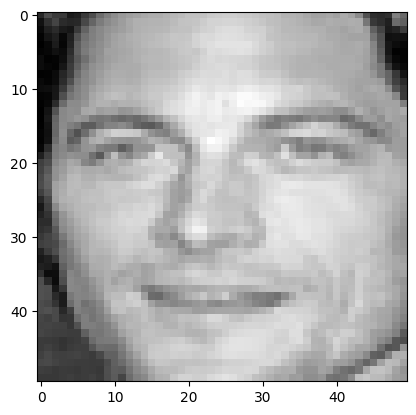

In [6]:
def tensor2img(img):
  npimg = img.numpy()
  if len(npimg.shape) > 2:
      npimg = np.transpose(img, [1, 2, 0])
  return npimg
img, label = dataloader[0][0][11][0], dataloader[0][1][11]
label = int(np.array(label))
print(class_names[label])
plt.figure
plt.imshow(tensor2img(img),'gray')

In [ ]:
print(dataloader[0][1][11])

tensor(0)


In [7]:
res50 =  models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = res50.fc.in_features
res50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
res50.fc = nn.Linear(num_ftrs, 2,bias=True)
torch.save(res50.state_dict(), 'default_params')


In [ ]:
res50

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
train_test_split = int(0.8*len(dataloader))
print(train_test_split)

732


In [11]:
training_data_full = dataloader[:train_test_split]
testing_data = dataloader[train_test_split:]
train_val_split = int(0.8*len(dataloader))
training_data = training_data_full[:train_val_split]
val_data = training_data_full[train_val_split:]

#Hyperparameter Search


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [17]:

import torch.optim as optim
import time

def train_model(model, criterion, optimizer, training_data,val_data, num_epochs=25):
    start_time = time.time()
      
    iters = 0
    running_loss = 0.0
    running_corrects=0
    log_iter=731
    final_val_acc = 0
    for ep in range(num_epochs):
      for phase in ['train','val'] :
        print(" PHASE : ",phase)
        if phase=='train':
          model.train()
          loader = training_data
        else:
          acc = 0.0
          count = 0
          model.eval()  
          loader = val_data  
        for iter, (inputs, labels) in enumerate(loader):
          iters += 1
          ips = Variable(inputs).float()
          lbs = Variable(labels).long()
          ips = ips.to(device)
          lbs = lbs.to(device)

          outputs = model(ips)
          if phase == 'train':
            loss = criterion(outputs, lbs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
            if iter % log_iter == 0:
              print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
          else:
            count += inputs.shape[0]
            acc += torch.sum(outputs.max(1)[1]==lbs)
        if phase == 'val':
            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
            print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
            final_val_acc = acc/count
    
    return final_val_acc



In [12]:



params = {
    'lr': [0.00015, 0.001, 0.01, 0.02],
    'max_epochs': [10, 20 ,25],
}
res50 = res50.to(device)
lr_best = -1
epoch_best = -1
best_val_acc = 0
for lr in params['lr']:
  for epochs in params['max_epochs']:
    res50.load_state_dict(torch.load('default_params'))
    val_acc = train_model(res50, nn.CrossEntropyLoss(), optim.Adam(res50.parameters(),lr=lr), training_data,val_data, epochs)
    print(" LR = ",lr," | Epochs = ",epochs," |  Validation Accuracy = ",val_acc)
    if(val_acc>best_val_acc):
      best_val_acc = val_acc
      lr_best = lr
      epoch_best = epochs
with open("param.csv", 'w') as output:
    output.write("Best Parameters : \n")
    output.write(str(lr_best)+","+str(epoch_best)+" \n")
    output.close() 


 PHASE :  train
Epoch: 1 | Iter:    0 | Time: 00:00:04 | Train Loss: 0.7124 | Average Loss: 0.7124 
 PHASE :  val
Accuracy: 0.948489 | Time: 00:01:04
 PHASE :  train
Epoch: 2 | Iter:    0 | Time: 00:01:04 | Train Loss: 0.1702 | Average Loss: 0.1879 
 PHASE :  val
Accuracy: 0.950721 | Time: 00:02:04
 PHASE :  train
Epoch: 3 | Iter:    0 | Time: 00:02:04 | Train Loss: 0.0992 | Average Loss: 0.1439 
 PHASE :  val
Accuracy: 0.947974 | Time: 00:03:05
 PHASE :  train
Epoch: 4 | Iter:    0 | Time: 00:03:05 | Train Loss: 0.0383 | Average Loss: 0.1198 
 PHASE :  val
Accuracy: 0.950034 | Time: 00:04:06
 PHASE :  train
Epoch: 5 | Iter:    0 | Time: 00:04:06 | Train Loss: 0.0260 | Average Loss: 0.1040 
 PHASE :  val
Accuracy: 0.944025 | Time: 00:05:06
 PHASE :  train
Epoch: 6 | Iter:    0 | Time: 00:05:07 | Train Loss: 0.0440 | Average Loss: 0.0920 
 PHASE :  val
Accuracy: 0.943510 | Time: 00:06:17
 PHASE :  train
Epoch: 7 | Iter:    0 | Time: 00:06:17 | Train Loss: 0.0237 | Average Loss: 0.0825 


In [14]:
print(lr_best," ",epoch_best)

0.00015   20


In [15]:
with open("param.csv", 'w') as output:
    output.write("Best Parameters : \n")
    output.write(str(lr_best)+","+str(epoch_best)+" \n")
    output.close() 


In [ ]:
net.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', '_params_to_validate', 'iterator_train__shuffle', 'classes', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__valid_acc', 'callbacks__valid_acc__scoring', 'callbacks__valid_acc__lower_is_better', 'callbacks__valid_acc__on_train', 'callbacks__valid_acc__name', 'callbacks__valid_acc__target_extractor', 'callbacks__valid_acc__use_caching', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign

#Training:

In [19]:
res50 = res50.to(device)
train_model(res50, nn.CrossEntropyLoss(), optim.Adam(res50.parameters(),lr=lr_best),training_data_full,testing_data ,epoch_best)

 PHASE :  train
Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0626 | Average Loss: 0.0626 
Epoch: 1 | Iter:  731 | Time: 00:01:05 | Train Loss: 0.1229 | Average Loss: 0.0841 
 PHASE :  val
Accuracy: 0.952191 | Time: 00:01:10
 PHASE :  train
Epoch: 2 | Iter:    0 | Time: 00:01:10 | Train Loss: 0.0560 | Average Loss: 0.0672 
Epoch: 2 | Iter:  731 | Time: 00:02:16 | Train Loss: 0.1125 | Average Loss: 0.0704 
 PHASE :  val
Accuracy: 0.953550 | Time: 00:02:21
 PHASE :  train
Epoch: 3 | Iter:    0 | Time: 00:02:21 | Train Loss: 0.0512 | Average Loss: 0.0633 
Epoch: 3 | Iter:  731 | Time: 00:03:28 | Train Loss: 0.1076 | Average Loss: 0.0651 
 PHASE :  val
Accuracy: 0.954314 | Time: 00:03:32
 PHASE :  train
Epoch: 4 | Iter:    0 | Time: 00:03:32 | Train Loss: 0.0478 | Average Loss: 0.0607 
Epoch: 4 | Iter:  731 | Time: 00:04:38 | Train Loss: 0.1056 | Average Loss: 0.0618 
 PHASE :  val
Accuracy: 0.954314 | Time: 00:04:43
 PHASE :  train
Epoch: 5 | Iter:    0 | Time: 00:04:43 | Train L

tensor(0.9535, device='cuda:0')

In [21]:
from datetime import date
today = date.today()
torch.save(res50.state_dict(), 'CSV_Models/res_'+str(today))

In [ ]:
# testing = dataloader[train_test_split:]
# test_num = len(testing)
# print("Finish loading %d  of testing samples." % (test_num))

Finish loading 184  of testing samples.


In [8]:
res50.load_state_dict(torch.load('CSV_Models/res_2022-12-03'))

<All keys matched successfully>

In [22]:
res50

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
acc=0
count=0
device = 'gpu'
with open("predictions.csv", 'w') as output:
  for i in range(2500):
    output.write(str(i)+",")
  output.write("Score,Prediction,True Label\n")
  output.close() 
for iter, (x, y) in enumerate(testing_data):
        count+= x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
          res50.cuda()
        outputs = res50(batch_x)
        cs = outputs.max(1)[0].cpu().detach().numpy()
        op = outputs.max(1)[1].cpu().detach().numpy()
        filex = x.numpy().reshape(64,2500)
        filey = y.numpy()
        for i in range(len(cs)):
          if(op[i]!=filey[i]):
            with open("predictions.csv", 'a+') as output:
              for feat in filex[i]:
                output.write(str(feat)+",")
              output.write(str(cs[i])+","+str(op[i])+" \n")
              output.close() 

In [ ]:
print('Correctly Classified : {:5f} '.format(acc))
print('Incorrectly Classified : {:5f} '.format(count-acc))

Correctly Classified : 11197.000000 
Incorrectly Classified : 579.000000 


In [ ]:
print('Accuracy : {:5f} '.format(acc/count))

Accuracy : 0.950832 


In [ ]:
from datetime import date

today = date.today()
print("Today's date:", today)

In [ ]:
device = 'gpu' if next(res50.parameters()).is_cuda else 'cpu'
misclassifications_male = []
misclassifications_female = []

for iter, (x, y) in enumerate(testing):
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = res50(batch_x)
        op = outputs.max(1)[1]
        for i in range(len(batch_y)):
         if op[i]!=batch_y[i] : 
           if(op[i].cpu().numpy()==1):
            misclassifications_male.append([batch_x[i],batch_y[i]])
           else:
             misclassifications_female.append([batch_x[i],batch_y[i]])

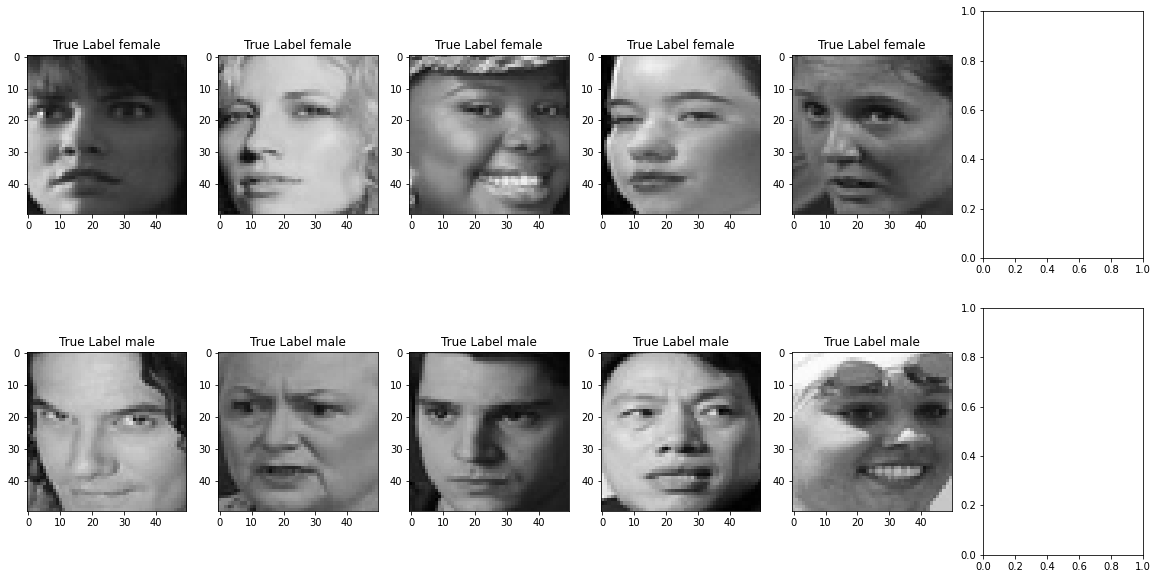

In [ ]:
from IPython.core.display import display, HTML
import pandas as pd
import base64

fig, ax = plt.subplots(2,6,figsize=(20,10))
for i in range(5):
    img_tensor = misclassifications_male[i][0][0].cpu().data
    im = tensor2img(img_tensor)
    label = misclassifications_male[i][1].cpu().data.numpy()
    #print(int(label))
    ax[0][i].set_title("True Label "+class_names[int(label)])
    ax[0][i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    img_tensor = misclassifications_female[i][0][0].cpu().data
    im = tensor2img(img_tensor)
    label = misclassifications_female[i][1].cpu().data.numpy()
    ax[1][i].set_title("True Label "+class_names[int(label)])
    ax[1][i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
acc=0
count=0
device = 'gpu'
y_test = []
y_proba = []
for iter, (x, y) in enumerate(testing):
        count+= x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
          res50.cuda()
        outputs = res50(batch_x)
        y_test += batch_y.cpu().data
        y_proba += outputs.max(1)[1].cpu().data
        #acc += torch.sum(outputs.max(1)[1]==batch_y)

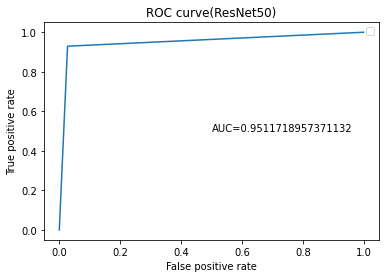

AUC: 0.951


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
auc = roc_auc_score(y_test, y_proba)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve(ResNet50)')
plt.legend(loc='best')
plt.text(.5, .5, "AUC="+ str(auc),color='black')
plt.show()
print('AUC: %.3f' % auc)